In [9]:
%load_ext autoreload
%autoreload 2
import json
import torch
import numpy as np
from transformers import T5ForConditionalGeneration, AutoTokenizer

from visualization.sample_wrapper import QASample
from visualization.data_utils import read_squad_example, QAInputFeatures, SquadExample, convert_qa_example_to_features, whitespace_tokenize, char_to_word_offset
from utils_T5 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'char_to_word_offset' from 'visualization.data_utils' (/Users/ironmonkeyapps/Desktop/Studium/Master/Semester2/DL/Project/How-Does-Bert-Answer-QA-DLP2021/src/visualization/data_utils.py)

In [12]:
# Loading finetuned T5 model and sample QA Task
tokenizer = AutoTokenizer.from_pretrained("t5-base") # ("../models/t5_finetuned_squad_v1")
model = T5ForConditionalGeneration.from_pretrained(
        "../models/t5_finetuned_squad_v1",
        cache_dir="/cache",
)

psample = QASample.from_json_file("./visualization/samples/sample_paper_squad.json")
psample: SquadExample = read_squad_example(psample)
pfeatures = convert_qa_example_to_features(
            example=psample,
            tokenizer=tokenizer,
            max_seq_length=384,
            doc_stride=128,
            max_query_length=64,
            is_training=False,
        )
print(pfeatures.sup_ids)

# prepare sample for input to model
sample = json.load(open("./visualization/samples/sample_paper_squad.json"))# QASample.from_json_file("./visualization/samples/sample_paper_squad.json")
sample["answers"] = {}
sample["answers"]['text'] = [sample['answer']]
print(sample["answers"]['text'])
sample = add_eos_to_examples(sample)
answer_start = sample["context"].lower().find(sample["answers"]['text'][0].lower())
print(sup_ids)
#print(sample)
# convert to batch like form
#sample["input_text"] = [sample["input_text"]]
#sample["target_text"] = [sample["target_text"]]
# tokenize sample
#features = convert_to_features(sample, tokenizer)

features = tokenizer([sample['input_text']], return_tensors='pt')


# convert to tensors
"""
features["input_ids"] = torch.Tensor(features["input_ids"]).long()
features["attention_mask"] = torch.Tensor(features["attention_mask"]).long()
features["target_ids"] = torch.Tensor(features["target_ids"]).long()
"""

# create tokens for visu
# tokens = ["[CLS]", ]
# tokens.extend(whitespace_tokenize(sample["question"]))
# tokens.append("[SEP]") # + tokenizer.tokenize(sample["context"]) + "[CLS]"
# tokens.extend(whitespace_tokenize(sample["context"]))
# tokens.append("[SEP]")
features["tokens"] = tokenizer.convert_ids_to_tokens(features["input_ids"][0])
print(features["tokens"], features["input_ids"][0])

[(14, 47)]
['detention']
[0, 142]
['▁question', ':', '▁What', '▁is', '▁', 'a', '▁common', '▁punishment', '▁in', '▁the', '▁UK', '▁and', '▁Ireland', '?', '▁context', ':', '▁', 'Currently', '▁de', 'tention', '▁is', '▁one', '▁of', '▁the', '▁most', '▁common', '▁pun', '-', '▁', 'ish', 'ments', '▁in', '▁schools', '▁in', '▁the', '▁United', '▁States', ',', '▁the', '▁UK', ',', '▁I', 're', '-', '▁land', ',', '▁Singapore', '▁and', '▁other', '▁countries', '.', '▁It', '▁requires', '▁the', '▁pupil', '▁to', '▁remain', '▁in', '▁school', '▁at', '▁', 'a', '▁given', '▁time', '▁in', '▁the', '▁school', '▁day', '▁(', 'such', '▁as', '▁lunch', ',', '▁rece', 's', 's', '▁or', '▁after', '▁school', ');', '▁or', '▁even', '▁to', '▁attend', '▁school', '▁on', '▁', 'a', '▁non', '-', 'school', '▁day', ',', '▁', 'e', '.', 'g', '.', '▁', "'", 'S', 'atur', 'day', '▁de', 'tention', "'", '▁held', '▁at', '▁some', '▁schools', '.', '▁', 'During', '▁de', 'tention', ',', '▁students', '▁normally', '▁have', '▁to', '▁sit', '▁in', '▁

In [13]:
# model with custom generated features
outs = model.generate(input_ids=features["input_ids"],
                        attention_mask=features["attention_mask"],
                        max_length=16,
                        early_stopping=True,
                        output_hidden_states=True,
                        return_dict_in_generate=True)

answer = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=True) for ids in outs.sequences]
encoder_hstates = outs.encoder_hidden_states

# parse answer tokens for visualization
ids = features["input_ids"][0].int().numpy()
answer_index = [np.where(ids==o.numpy())[0][0] for o in outs.sequences[0] if o != 0 and o != 1] # get only the first occurence of the answer.
question_end_indice = [i for i, e in enumerate(features["tokens"]) if 'context' in e][0]
question_index = [0, question_end_indice]
print(answer, outs.sequences, answer_index, question_index)



['detention'] tensor([[   0,   20, 9174,    1]]) [18, 19] [0, 14]


In [15]:
# move sample forward to get hidden states with custom out
out = model(input_ids=features['input_ids'], attention_mask=features["attention_mask"], decoder_input_ids=features['target_ids'], output_hidden_states=True, return_dict=True)

encoder_hstates = out.encoder_hidden_states[:-1]
print(len(encoder_hstates))

12


12


2021-07-06 22:43:28,184 No output path specified.


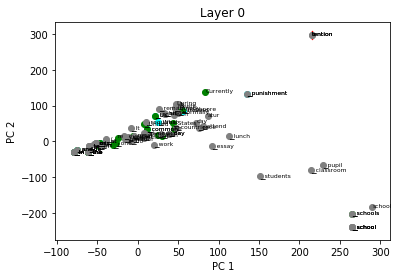

2021-07-06 22:43:29,641 No output path specified.


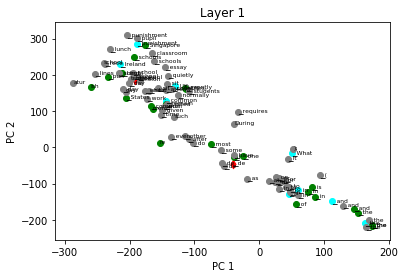

2021-07-06 22:43:30,790 No output path specified.


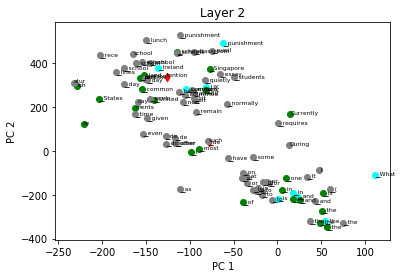

2021-07-06 22:43:31,827 No output path specified.


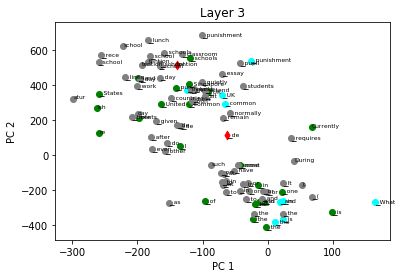

2021-07-06 22:43:32,707 No output path specified.


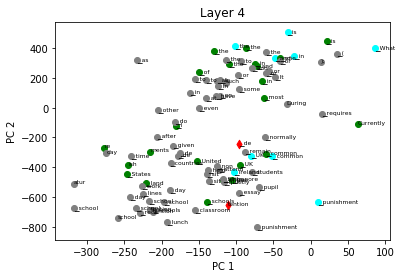

2021-07-06 22:43:33,655 No output path specified.


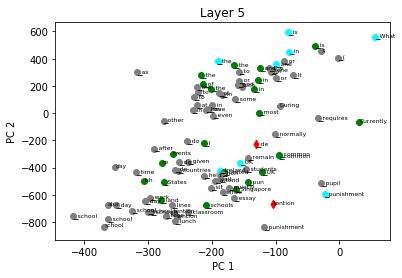

2021-07-06 22:43:34,497 No output path specified.


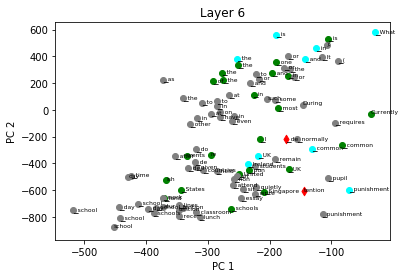

2021-07-06 22:43:35,375 No output path specified.


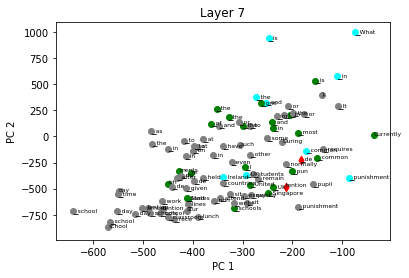

2021-07-06 22:43:36,244 No output path specified.


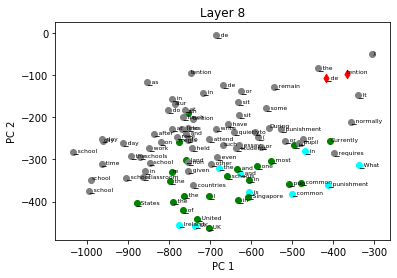

2021-07-06 22:43:37,577 No output path specified.


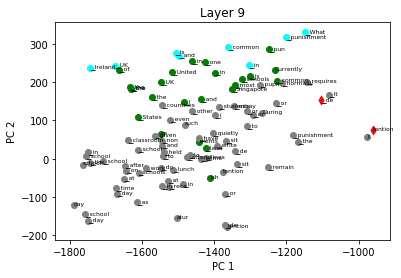

2021-07-06 22:43:38,497 No output path specified.


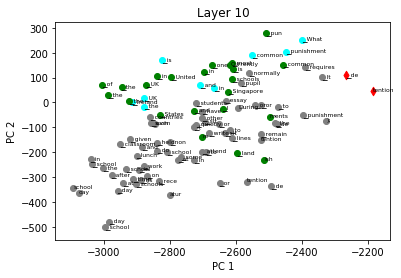

2021-07-06 22:43:39,315 No output path specified.


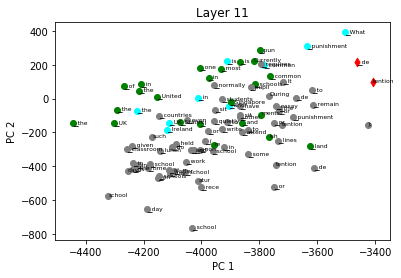

2021-07-06 22:43:40,103 No output path specified.


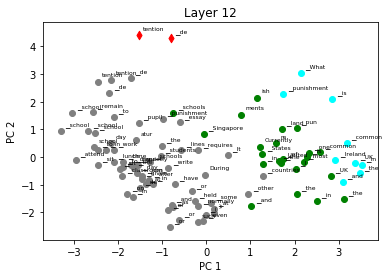

<Figure size 432x288 with 0 Axes>

In [17]:
from sklearn.decomposition import PCA
from visualization.plotting import Token2DVector, TokenPlotter, TokenLabel
from typing import List
tokens = features["tokens"]
sup_facts_pos = pfeatures.sup_ids
for index, layer in enumerate(encoder_hstates):
    token_vectors: List = layer[0][:len(tokens)]
    reduction = PCA(n_components=2)
    layer_reduced = reduction.fit_transform(token_vectors.detach().numpy()).transpose()

    token_vectors = []
    for token_index, value in enumerate(layer_reduced[0]):  # iterate over x-values
        label = TokenLabel.DEFAULT
        is_supporting_fact_token = False
        for sup_fact_pos in sup_facts_pos:
            if sup_fact_pos[0] <= token_index <= sup_fact_pos[1]:
                is_supporting_fact_token = True
                break
        if is_supporting_fact_token:
            label = TokenLabel.SUP_FACT
        if token_index >= answer_index[0] and token_index <= answer_index[1]:
            label = TokenLabel.PREDICTION
        elif token_index >= question_index[0] and token_index <= question_index[1]:
            label = TokenLabel.QUESTION

        token_vector = Token2DVector(x=value,
                                    y=layer_reduced[1][token_index],
                                    token=tokens[token_index],
                                    label=label)
        token_vectors.append(token_vector)
    plot_title = "Layer {}".format(index)
    token_plotter = TokenPlotter(vectors=token_vectors,
                                    title=plot_title,
                                    output_path=None)
    token_plotter.plot()